<a href="https://colab.research.google.com/github/gulshan0201/DATA-Science/blob/main/Project_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Load datasets
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print("===== ORIGINAL TRAIN DATA (First 5 Rows) =====")
print(train_df.head())

print("\nShape of Original Train Data:", train_df.shape)

print("\n===== ORIGINAL TEST DATA (First 5 Rows) =====")
print(test_df.head())

print("\nShape of Original Test Data:", test_df.shape)


===== ORIGINAL TRAIN DATA (First 5 Rows) =====
   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  

Shape of Original Train Data: (45211, 17)

===== ORIGINAL TEST 

In [ ]:
import numpy as np

def add_engineered_features(df):
    # --------------------------------------------------------
    # 1. Customer_Stability_Score (CSS)
    # Formula:
    # CSS = ln(balance + 1) + 1 if default == 'no', else 0
    df["Customer_Stability_Score"] = np.log1p(df["balance"]) + (df["default"] == "no").astype(int)

    # --------------------------------------------------------
    # 2. Engagement_Intensity_Index (EII)
    # Formula:
    # EII = duration / (campaign + 1) + previous
    df["Engagement_Intensity_Index"] = df["duration"] / (df["campaign"] + 1) + df["previous"]

    # --------------------------------------------------------
    # 3. Campaign_Fatigue_Indicator (CFI)
    # Formula:
    # CFI = campaign / (duration + 1)
    df["Campaign_Fatigue_Indicator"] = df["campaign"] / (df["duration"] + 1)

    return df

# Apply feature engineering
train_new = add_engineered_features(train_df.copy())
test_new = add_engineered_features(test_df.copy())


/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
print("===== UPDATED TRAIN DATA WITH NEW FEATURES =====")
print(train_new[[
    "balance", "default", "duration", "campaign", "previous",
    "Customer_Stability_Score",
    "Engagement_Intensity_Index",
    "Campaign_Fatigue_Indicator"
]].head())

print("\n===== SHAPE AFTER FEATURE ENGINEERING =====")
print(train_new.shape)


===== UPDATED TRAIN DATA WITH NEW FEATURES =====
   balance default  duration  campaign  previous  Customer_Stability_Score  \
0     2143      no       261         1         0                  8.670429   
1       29      no       151         1         0                  4.401197   
2        2      no        76         1         0                  2.098612   
3     1506      no        92         1         0                  8.317876   
4        1      no       198         1         0                  1.693147   

   Engagement_Intensity_Index  Campaign_Fatigue_Indicator  
0                       130.5                    0.003817  
1                        75.5                    0.006579  
2                        38.0                    0.012987  
3                        46.0                    0.010753  
4                        99.0                    0.005025  

===== SHAPE AFTER FEATURE ENGINEERING =====
(45211, 20)


# Accuracy improvement before vs after these **features**

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# -----------------------------
# Load train data
# -----------------------------
df = pd.read_csv("train.csv")

print("===== ORIGINAL TRAIN DATA (First 5 Rows) =====")
print(df.head())
print("\nShape:", df.shape)


===== ORIGINAL TRAIN DATA (First 5 Rows) =====
   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  

Shape: (45211, 17)


# Define Engineered Features Function

In [ ]:
def add_engineered_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds:
    - Customer_Stability_Score
    - Engagement_Intensity_Index
    - Campaign_Fatigue_Indicator
    """
    # 1. Customer_Stability_Score = ln(balance + 1) + 1 if default == 'no' else 0
    df["Customer_Stability_Score"] = np.log1p(df["balance"]) + (df["default"] == "no").astype(int)

    # 2. Engagement_Intensity_Index = duration / (campaign + 1) + previous
    df["Engagement_Intensity_Index"] = df["duration"] / (df["campaign"] + 1) + df["previous"]

    # 3. Campaign_Fatigue_Indicator = campaign / (duration + 1)
    df["Campaign_Fatigue_Indicator"] = df["campaign"] / (df["duration"] + 1)

    return df


# Prepare Columns & Helper to Build Pipeline

In [ ]:
# Target variable
target_col = "y"

# Original feature columns (without target)
original_features = [
    "age", "job", "marital", "education", "default",
    "balance", "housing", "loan", "contact", "day",
    "month", "duration", "campaign", "pdays",
    "previous", "poutcome"
]

# Numeric and categorical features
numeric_features_original = ["age", "balance", "day", "duration", "campaign", "pdays", "previous"]
categorical_features = [
    "job", "marital", "education", "default",
    "housing", "loan", "contact", "month", "poutcome"
]


def build_pipeline(numeric_features, categorical_features):
    """
    Creates a preprocessing + Logistic Regression pipeline
    """
    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown="ignore")

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ]
    )

    model = LogisticRegression(max_iter=1000)

    clf = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])

    return clf


# Split Data Once (Same Split for Both Models)

In [ ]:
# Features (X) and Target (y)
X = df[original_features].copy()
y = df[target_col]

# Train-test split (same for both models)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape, " Test size:", X_test.shape)


Train size: (36168, 16)  Test size: (9043, 16)


# BASELINE MODEL (Before New Features)

In [ ]:
# Build pipeline with ORIGINAL numeric features only
clf_baseline = build_pipeline(
    numeric_features=numeric_features_original,
    categorical_features=categorical_features
)

# Train baseline model
clf_baseline.fit(X_train, y_train)

# Predict and evaluate
y_pred_base = clf_baseline.predict(X_test)
baseline_accuracy = accuracy_score(y_test, y_pred_base)

print(f"\n🔹 Baseline Accuracy (before new features): {baseline_accuracy:.4f}")



🔹 Baseline Accuracy (before new features): 0.9012


# MODEL WITH ENGINEERED FEATURES (After)

In [ ]:
# Make a copy and add engineered features
df_eng = df.copy()
df_eng = add_engineered_features(df_eng)

# Define new feature list (original + engineered)
engineered_feature_cols = original_features + [
    "Customer_Stability_Score",
    "Engagement_Intensity_Index",
    "Campaign_Fatigue_Indicator"
]

# New numeric features list (add the 3 new ones)
numeric_features_eng = numeric_features_original + [
    "Customer_Stability_Score",
    "Engagement_Intensity_Index",
    "Campaign_Fatigue_Indicator"
]

# Re-split using same random_state (to be fair)
X_eng = df_eng[engineered_feature_cols]
y_eng = df_eng[target_col]

X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(
    X_eng, y_eng, test_size=0.2, random_state=42, stratify=y_eng
)

# --- FIX START ---
# Address potential -inf or NaN values generated by add_engineered_features
# The ValueError: Input X contains infinity or a value too large for dtype('float64')
# likely originates from the Customer_Stability_Score where log1p of negative balance
# can produce -infinity or NaN. StandardScaler cannot handle infinite values.
for col in ["Customer_Stability_Score", "Engagement_Intensity_Index", "Campaign_Fatigue_Indicator"]:
    if col in X_train_eng.columns:
        X_train_eng[col] = X_train_eng[col].replace([np.inf, -np.inf], np.nan)
        X_train_eng[col] = X_train_eng[col].fillna(0) # Fill NaNs with 0
    if col in X_test_eng.columns:
        X_test_eng[col] = X_test_eng[col].replace([np.inf, -np.inf], np.nan)
        X_test_eng[col] = X_test_eng[col].fillna(0) # Fill NaNs with 0
# --- FIX END ---

# Build pipeline with extended numeric features
clf_eng = build_pipeline(
    numeric_features=numeric_features_eng,
    categorical_features=categorical_features
)

# Train enhanced model
clf_eng.fit(X_train_eng, y_train_eng)

# Predict and evaluate
y_pred_eng = clf_eng.predict(X_test_eng)
enhanced_accuracy = accuracy_score(y_test_eng, y_pred_eng)

print(f"🔹 Enhanced Accuracy (after new features): {enhanced_accuracy:.4f}")


/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


🔹 Enhanced Accuracy (after new features): 0.9022


# Compare Accuracy (Print & Plot)


================= ACCURACY COMPARISON =================
Baseline model (without new features): 0.9012
Enhanced model (with new features)   : 0.9022
Improvement                          : 0.0010


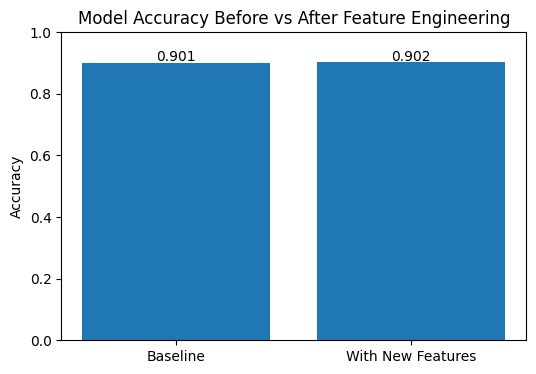

In [ ]:
print("\n================= ACCURACY COMPARISON =================")
print(f"Baseline model (without new features): {baseline_accuracy:.4f}")
print(f"Enhanced model (with new features)   : {enhanced_accuracy:.4f}")
print(f"Improvement                          : {enhanced_accuracy - baseline_accuracy:.4f}")

# --- Bar chart comparison ---
models = ["Baseline", "With New Features"]
accuracies = [baseline_accuracy, enhanced_accuracy]

plt.figure(figsize=(6, 4))
plt.bar(models, accuracies)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Before vs After Feature Engineering")
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.005, f"{v:.3f}", ha="center")
plt.ylim(0, 1)
plt.show()


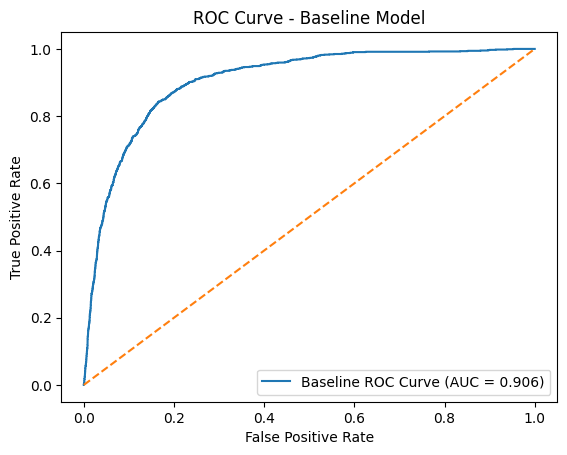

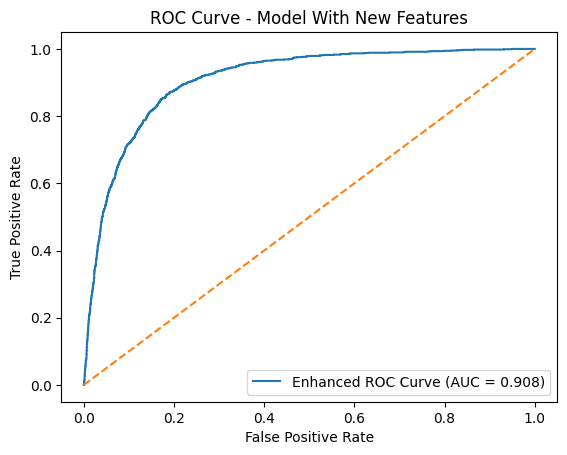

========== ROC AUC COMPARISON ==========
Baseline AUC : 0.9056
Enhanced AUC : 0.9082
AUC Improvement : 0.0027


In [14]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Convert target to binary (yes=1, no=0)
y_test_binary = y_test.map({'no': 0, 'yes': 1})
y_test_eng_binary = y_test_eng.map({'no': 0, 'yes': 1})

# ===============================
# ROC Curve - Baseline Model
# ===============================

y_prob_base = clf_baseline.predict_proba(X_test)[:, 1]
fpr_base, tpr_base, _ = roc_curve(y_test_binary, y_prob_base)
roc_auc_base = auc(fpr_base, tpr_base)

plt.figure()
plt.plot(fpr_base, tpr_base, label=f"Baseline ROC Curve (AUC = {roc_auc_base:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Baseline Model")
plt.legend()
plt.show()


# ===============================
# ROC Curve - Enhanced Model
# ===============================

y_prob_eng = clf_eng.predict_proba(X_test_eng)[:, 1]
fpr_eng, tpr_eng, _ = roc_curve(y_test_eng_binary, y_prob_eng)
roc_auc_eng = auc(fpr_eng, tpr_eng)

plt.figure()
plt.plot(fpr_eng, tpr_eng, label=f"Enhanced ROC Curve (AUC = {roc_auc_eng:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Model With New Features")
plt.legend()
plt.show()


# ===============================
# Print AUC Comparison
# ===============================

print("========== ROC AUC COMPARISON ==========")
print(f"Baseline AUC : {roc_auc_base:.4f}")
print(f"Enhanced AUC : {roc_auc_eng:.4f}")
print(f"AUC Improvement : {roc_auc_eng - roc_auc_base:.4f}")
